In [1]:
import torch
import pandas as pd
import numpy as np
from numpy import random
import torch.nn as nn
from modules import EDMPrecond
from diffusion import *
from utils import *
from evaluate import *
from torch.amp import autocast
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from tabulate import tabulate

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Make predictions on test data

In [2]:
path = "models/edm_e5_bs16_do10_no-cg/ema_ckpt.pt"
print("Loading: ", path)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = EDMPrecond(resolution      = 1024,
                   channels        = 1,
                   label_dim       = 3,
                   use_fp16        = False,
                   sigma_min       = 0,
                   sigma_max       = float('inf'),
                   sigma_data      = 0.5,
                   model_type      = 'UNet_conditional',
                   device=device
                    ).to(device)
ckpt = torch.load(path,
                  map_location=device,
                  weights_only=True
                  )
model.load_state_dict(ckpt)

sampler = EdmSampler(net=model, num_steps=100)

Loading:  models/edm_e5_bs16_do10_no-cg/ema_ckpt.pt
Using device: cuda:0


In [3]:
x_real, cond_vectors, predictions = evaluate(model,
                      sampler,
                      device,
                      "../data/test_data_1024_[-1,1].csv",
                                            s_type='edm'
                                            )
x_real = np.array(x_real)
cond_vectors = np.array(cond_vectors)
predictions = np.array(predictions)

Testing loop: 100%|███████████████████████████████████████| 1567/1567 [47:36<00:00,  1.82s/it]


In [9]:
mse = np.mean((x_real - predictions) ** 2)
print(f"Mean test mse error: {mse}")

Mean test mse error: 0.009436078947973745


In [ ]:
x_real

In [12]:
predictions

array([[-0.96283507, -0.97761238, -0.97147685, ..., -0.9641161 ,
        -0.94841725, -0.92820203],
       [-0.98583883, -0.99181783, -0.98967195, ..., -0.98698145,
        -0.98792177, -0.98538268],
       [-0.98095548, -0.98960853, -0.98831087, ..., -0.98457193,
        -0.98601949, -0.97440219],
       ...,
       [-1.        , -0.84298646, -0.89943141, ..., -0.8910318 ,
        -0.88349152, -0.84469032],
       [-0.98951107, -0.99572158, -0.99309748, ..., -0.98917592,
        -0.98784626, -0.97748393],
       [-0.9624247 , -0.97576964, -0.97785926, ..., -0.96726996,
        -0.97147518, -1.        ]])

In [ ]:
cond_vectors

# Save predictions

In [13]:
x_real_str = [','.join(map(str, row)) for row in x_real]
cond_vectors_str = [','.join(map(str, row)) for row in cond_vectors]
preds_str = [','.join(map(str, row)) for row in predictions[:,0,0,:]]

df = pd.DataFrame({'x_real': x_real_str, 'cond_vectors': cond_vectors_str, 'predictions': preds_str})
df.to_csv('results/predictions/preds_edm_e5_bs16_do10_no-cg.csv', index=False)

In [14]:
df.head()

,x_real,cond_vectors,predictions
0,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.3163244128227234,0.3391146957874298,0.0","-0.9628350734710693,-0.9776123762130737,-0.971..."
1,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.27736008167266846,0.44142237305641174,0.0","-0.9858388304710388,-0.991817831993103,-0.9896..."
2,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.6772092580795288,0.2812798023223877,0.0","-0.9809554815292358,-0.9896085262298584,-0.988..."
3,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.5888327956199646,0.7273106575012207,0.0","-0.8455108404159546,-0.8142553567886353,-0.930..."
4,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.3009049892425537,0.22526775300502777,0.0","-0.9870526790618896,-0.9831535816192627,-0.983..."


In [15]:
# Load data
df = pd.read_csv('results/predictions/preds_edm_UNet_1024.csv')

# Function to convert comma-separated strings to lists of floats
def str_to_float_list(s):
    return np.array(list(map(float, s.split(','))))

x_real = np.array([str_to_float_list(row) for row in df['x_real']])
cond_vectors = np.array([str_to_float_list(row) for row in df['cond_vectors']])
predictions = np.array([str_to_float_list(row) for row in df['predictions']])

df.head()

,x_real,cond_vectors,predictions
0,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.3163244128227234,0.3391146957874298,0.0","-0.9628350734710693,-0.9776123762130737,-0.971..."
1,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.27736008167266846,0.44142237305641174,0.0","-0.9858388304710388,-0.991817831993103,-0.9896..."
2,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.6772092580795288,0.2812798023223877,0.0","-0.9809554815292358,-0.9896085262298584,-0.988..."
3,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.5888327956199646,0.7273106575012207,0.0","-0.8455108404159546,-0.8142553567886353,-0.930..."
4,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.3009049892425537,0.22526775300502777,0.0","-0.9870526790618896,-0.9831535816192627,-0.983..."


# Intro into data

In [16]:
# Find indices and values greater than 0.5
indices = np.where(np.any(x_real > 0.5, axis=1))[0]
filtered_values = [x_real[idx][x_real[idx] > 0.5] for idx in indices]
filtered_predictions = [predictions[idx][x_real[idx] > 0.5] for idx in indices]

# Flatten results and take the first 50
flat_filtered_values = np.concatenate(filtered_values)[:50]
flat_filtered_predictions = np.concatenate(filtered_predictions)[:50]

# Print the results side by side
print("Filtered Values (greater than 0.5) from x_real and corresponding Predictions:")
for value, prediction in zip(flat_filtered_values, flat_filtered_predictions):
    print(f"{value:.5f}\t\t\t{prediction:.5f}")

Filtered Values (greater than 0.5) from x_real and corresponding Predictions:
0.51407			0.54484
0.65096			0.68111
0.78482			0.80181
0.89267			0.90088
0.97221			0.95111
1.00000			1.00000
1.00000			0.94416
1.00000			0.95395
0.96727			0.91944
0.82849			0.75859
0.73080			0.64724
0.61790			0.54792
0.52190			0.44448
0.55391			0.75181
0.67699			0.86447
0.78227			0.94874
0.87054			0.99633
0.94814			1.00000
0.91525			0.96570
0.96301			0.95006
0.90360			0.85924
0.78227			0.71861
0.70256			0.58596
0.59787			0.47198
0.50855			0.36704
0.54796			0.58981
0.68742			0.73774
0.81460			0.85473
0.90345			0.94020
0.95629			0.99243
1.00000			1.00000
0.93835			0.96368
0.95377			0.95399
0.87022			0.86335
0.72938			0.72199
0.62246			0.58499
0.50288			0.47386
0.54077			0.58319
0.68126			0.74225
0.81203			0.89174
0.91680			0.97861
0.97169			0.95808
1.00000			1.00000
0.97584			0.94348
1.00000			0.98416
0.92773			0.86804
0.78535			0.70340
0.68151			0.63151
0.56501			0.56348
0.60578			0.55590


In [17]:
# Find indices where predictions > 0.8 and corresponding x_real < 0.5
indices = np.where((predictions > 0.8) & (x_real < 0.1))

# Extract filtered values from x_real and predictions
filtered_x_real = x_real[indices]
filtered_predictions = predictions[indices]

# Print the results side by side
print("Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):")
for x_val, pred_val in zip(filtered_x_real.flatten(), filtered_predictions.flatten()):
    print(f"{x_val:.5f}\t\t\t{pred_val:.5f}")

Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):


# Visualization of results

In [18]:
wavelengths = np.load('../data/wavelengths.npy')

In [19]:
wavelengths

array([ 634.835144,  635.296997,  635.758911, ..., 1123.063232,
       1123.557739, 1124.052368])

## Plot predictions

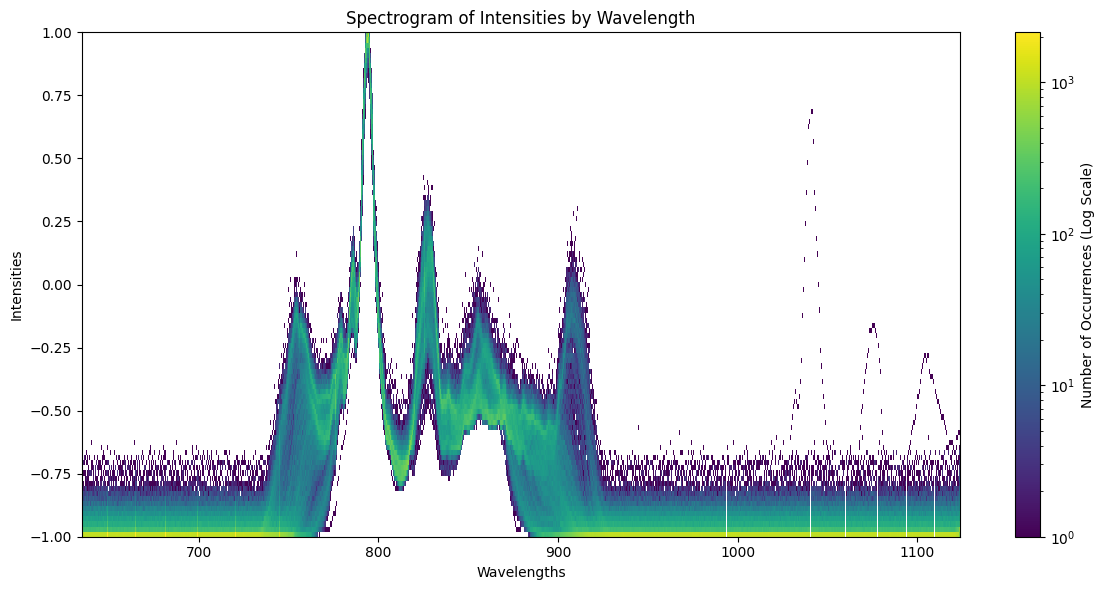

In [20]:
create_spectrogram(wavelengths, predictions, label="Spectrogram of Intensities by Wavelength")

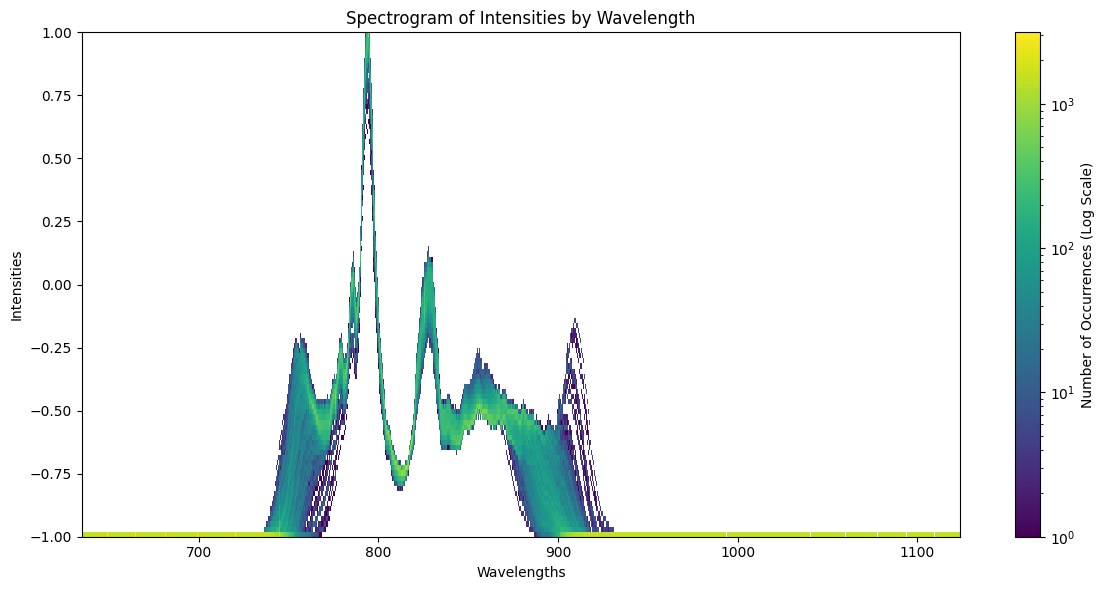

In [21]:
create_spectrogram(wavelengths, x_real, label="Spectrogram of Intensities by Wavelength")

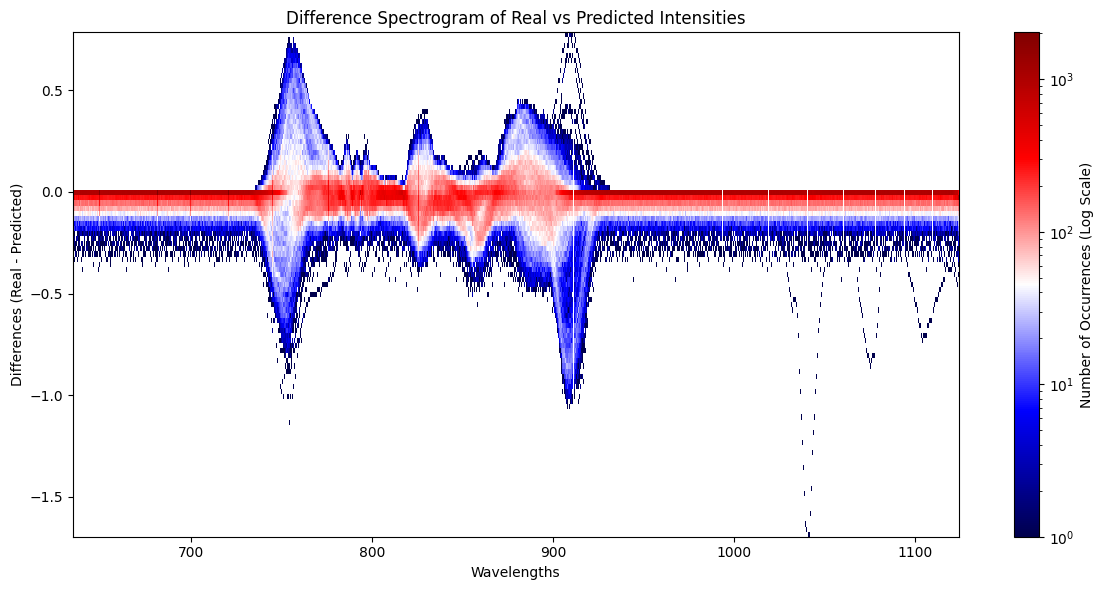

In [22]:
create_difference_spectrogram(wavelengths, 
                              x_real, 
                              predictions, 
                              label="Difference Spectrogram of Real vs Predicted Intensities")

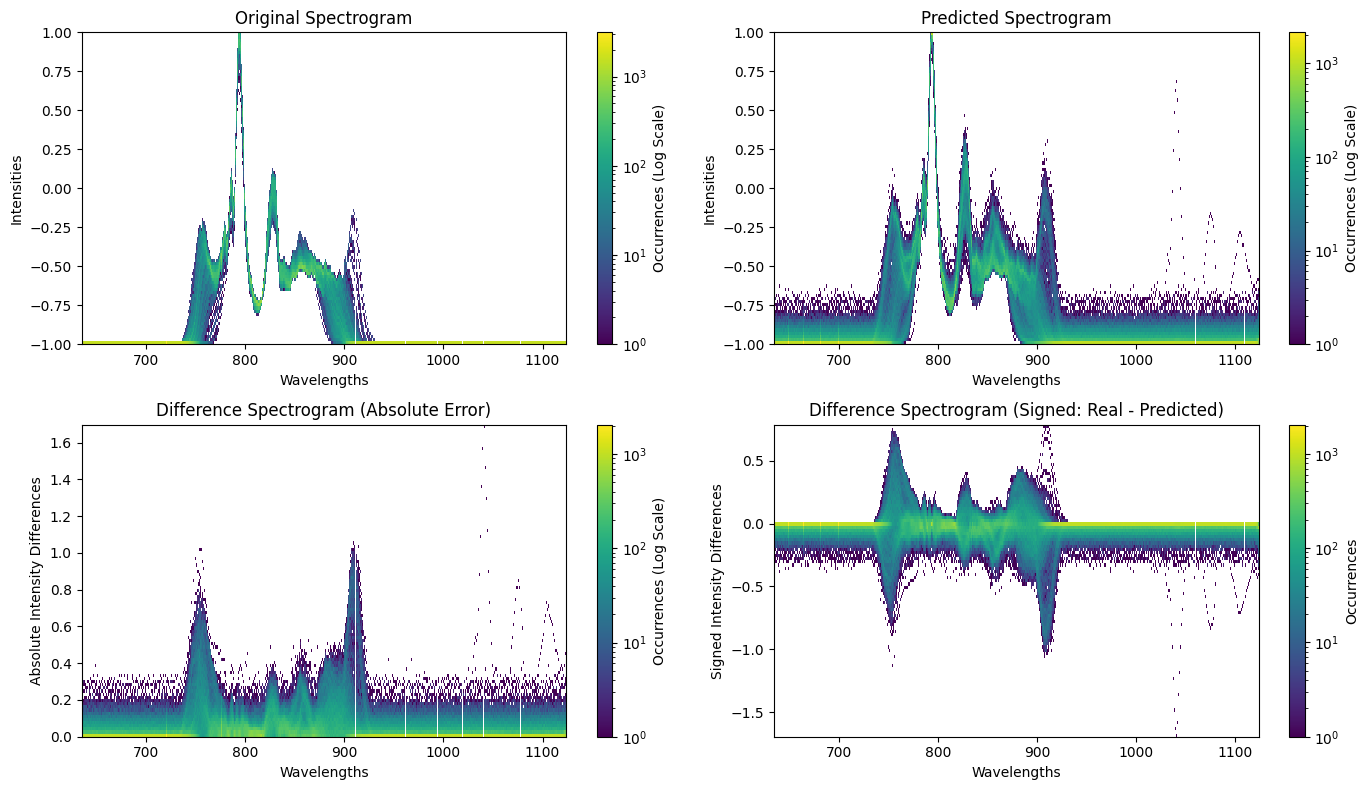

In [23]:
create_combined_spectrogram(wavelengths, 
                            x_real, 
                            predictions)

## Influence of parameters to predictions

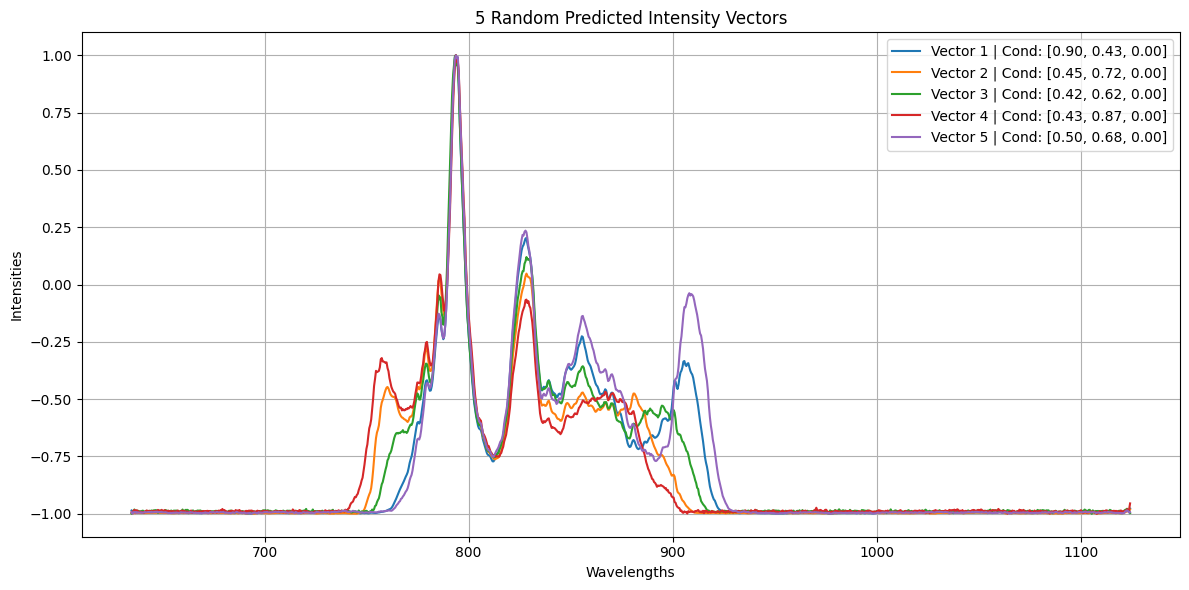

In [24]:
plot_random_intensity_vectors(wavelengths, predictions, cond_vectors)

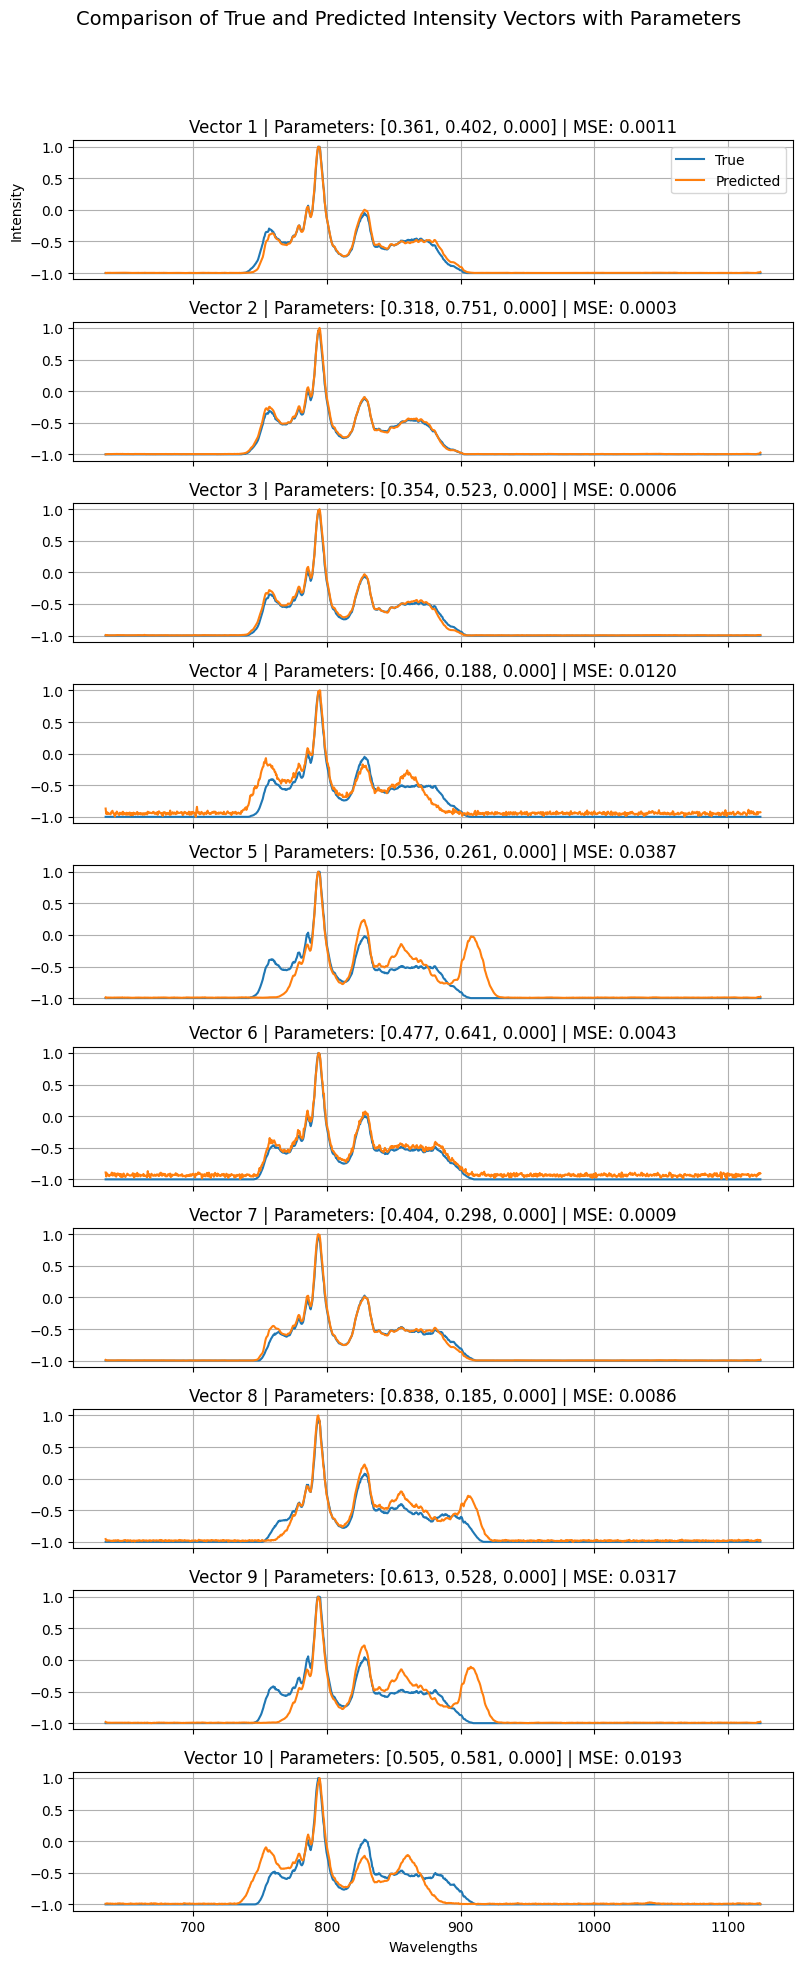

In [25]:
indices = np.random.choice(len(x_real), size=10, replace=False)

selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, indices, num_vectors=10
)

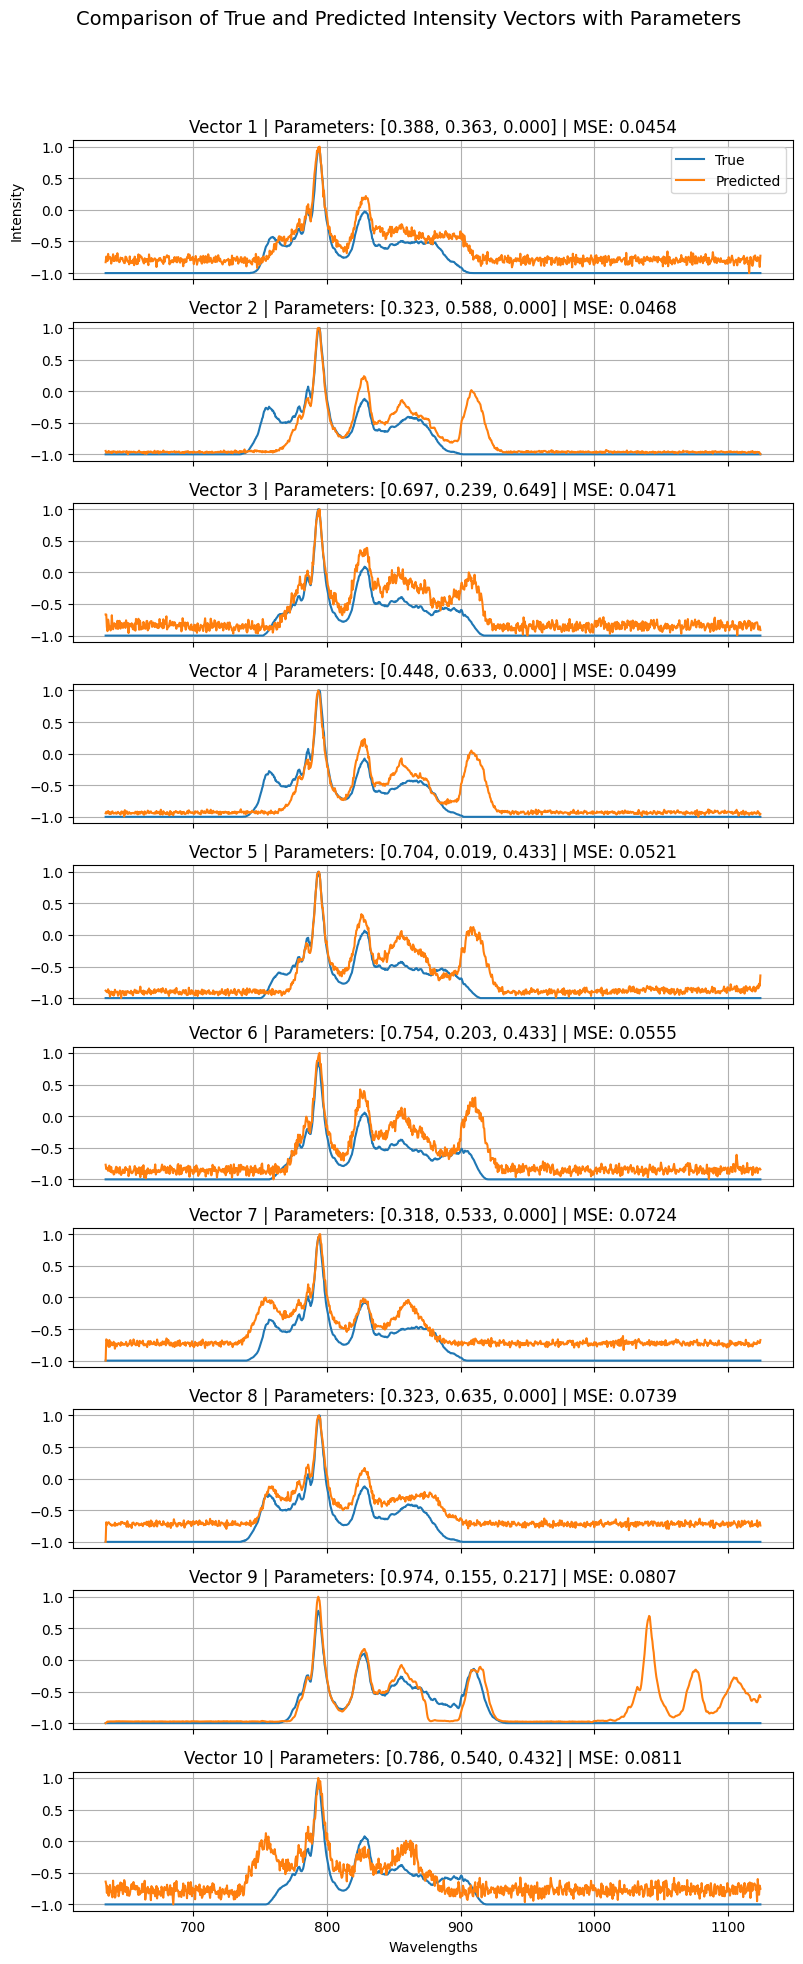

In [26]:
worst_indices = get_worst_mse_indices(x_real, predictions, n=10)
selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, worst_indices, num_vectors=10
)

MSE Statistics:
Mean: 0.0094
Median: 0.0061
Standard Deviation: 0.0100
Min: 0.0001
Max: 0.0811
Range: 0.0811
Median (Q2): 0.0061
First Quartile (Q1): 0.0021
Third Quartile (Q3): 0.0135
Interquartile Range (IQR): 0.0114
Upper Whisker: 0.0306
Number of Outliers: 73.0000
Outliers: [0.03142592784829046, 0.07386046134888481, 0.0811443152571267, 0.04991495690283131, 0.034602228311458774, 0.04213086014759178, 0.03094051084976729, 0.037680193174844806, 0.03332798801139487, 0.03254732903256538]...


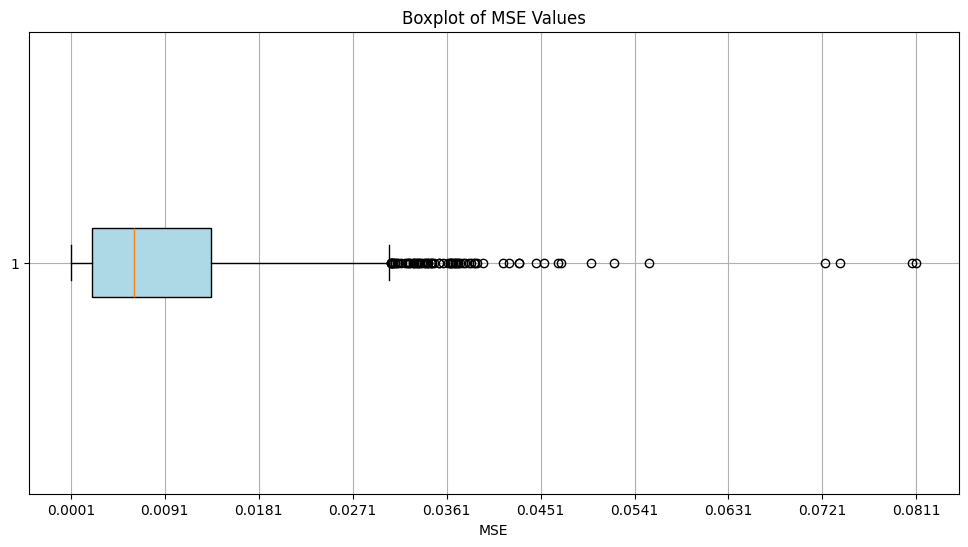

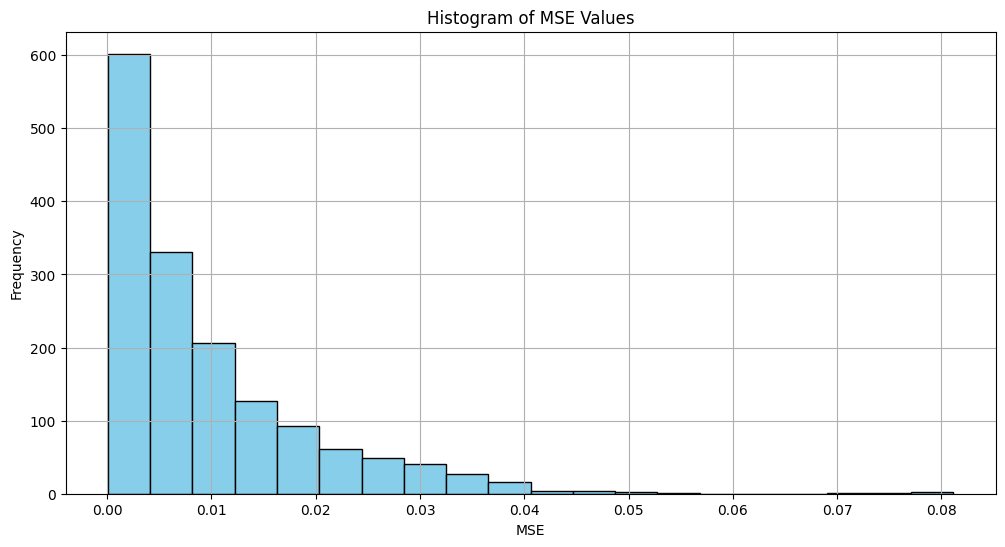

In [27]:
mse_stats = mse_statistics(x_real, predictions)


Number of vectors with high MSE (above upper whisker): 73
Number of vectors with low MSE (below or equal to upper whisker): 1494

Statistics for high MSE conditional vectors:
  Mean: [0.48639954 0.46286136 0.056303  ]
  Median: [0.47073519 0.49311617 0.        ]
  Std: [0.13867796 0.2232501  0.14770978]
  Min: [0.22388521 0.01863214 0.        ]
  Max: [0.97409213 0.95047712 0.64880955]

Statistics for low MSE conditional vectors:
  Mean: [0.43932626 0.45667209 0.00394036]
  Median: [0.41589317 0.46870887 0.        ]
  Std: [0.16942005 0.21255165 0.03690518]
  Min: [0.         0.00644275 0.        ]
  Max: [1.         1.         0.43452382]


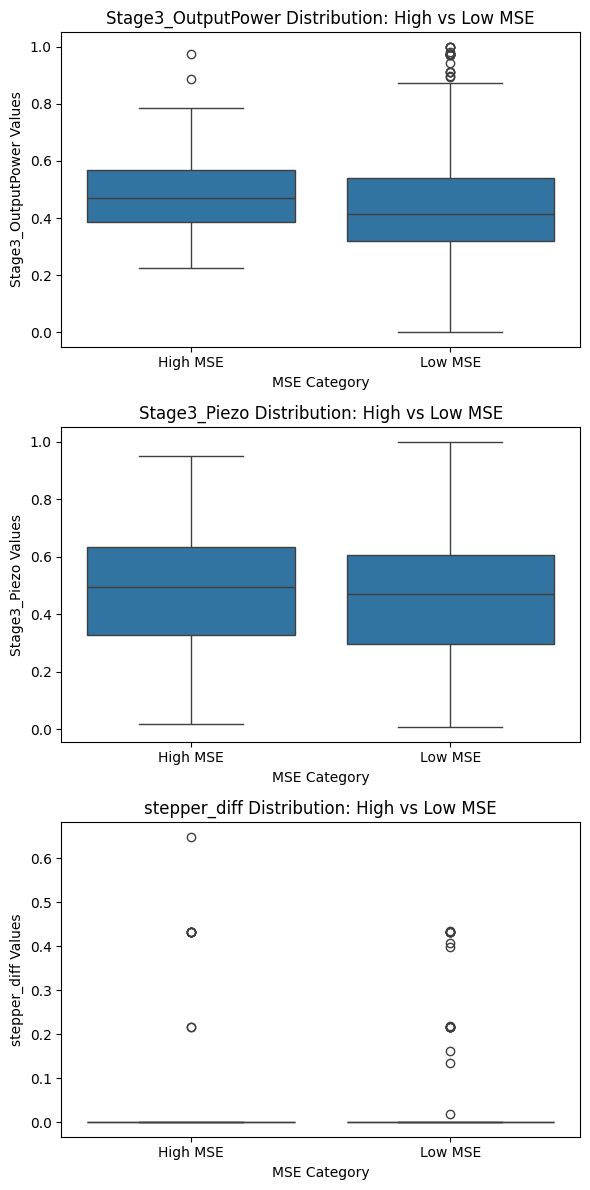

In [28]:
mse = np.mean((x_real - predictions) ** 2, axis=1)
parameter_names = ['Stage3_OutputPower', 'Stage3_Piezo', 'stepper_diff']
analyze_mse_and_cond_vectors(mse, cond_vectors, parameter_names)

## Try Random conditional vectors

In [29]:
x_real_nonsense, cond_vectors_nonsense, predictions_nonsense = evaluate(model,
                      sampler,
                      device,
                     "../data/data_nonsense.csv",
                                            s_type='edm')
x_real_nonsense = np.array(x_real_nonsense)
cond_vectors_nonsense = np.array(cond_vectors_nonsense)
predictions_nonsense = np.array(predictions_nonsense)[:,0,0,:]

Testing loop: 100%|███████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


In [30]:
predictions_nonsense

array([[-0.94059408, -0.59405941, -0.17821783, ...,  0.17821777,
         0.81188118, -0.17821783],
       [ 0.52598226,  0.24461341,  0.2877059 , ...,  0.34093785,
         0.0038023 ,  0.18124211],
       [ 0.37875283,  0.05542719, -0.53348732, ..., -0.22632796,
        -0.44341803, -0.51039261],
       ...,
       [-0.9589501 , -0.98339784, -0.9772622 , ..., -0.97113156,
        -0.97108841, -0.93994886],
       [-0.99395466, -0.99746984, -0.99417293, ..., -0.98895526,
        -0.99016684, -0.98106027],
       [-0.97979301, -0.98547381, -0.98579103, ..., -0.97927141,
        -0.9768647 , -0.96143073]])

In [31]:
x_real_nonsense

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

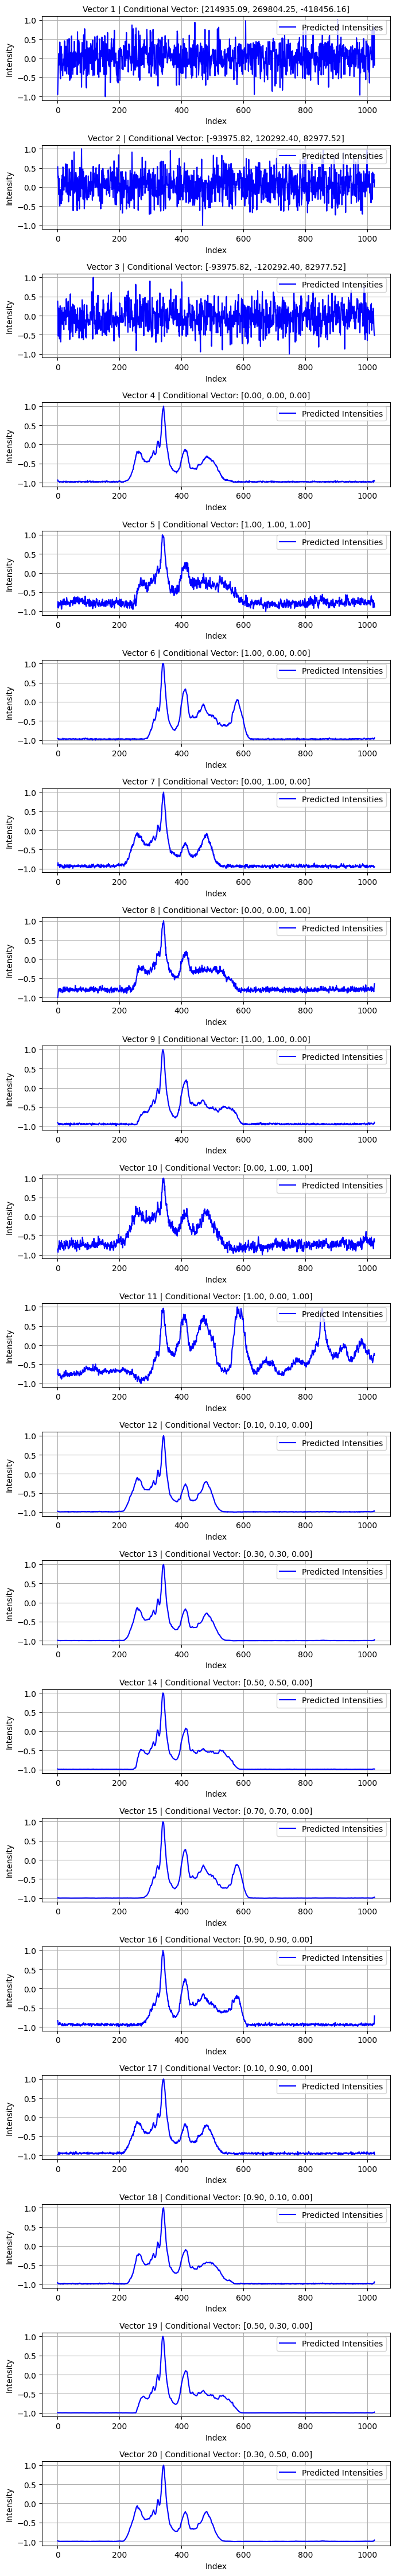

In [32]:
plot_predictions_with_cond_vectors(predictions_nonsense, cond_vectors_nonsense)

## Compare distributions

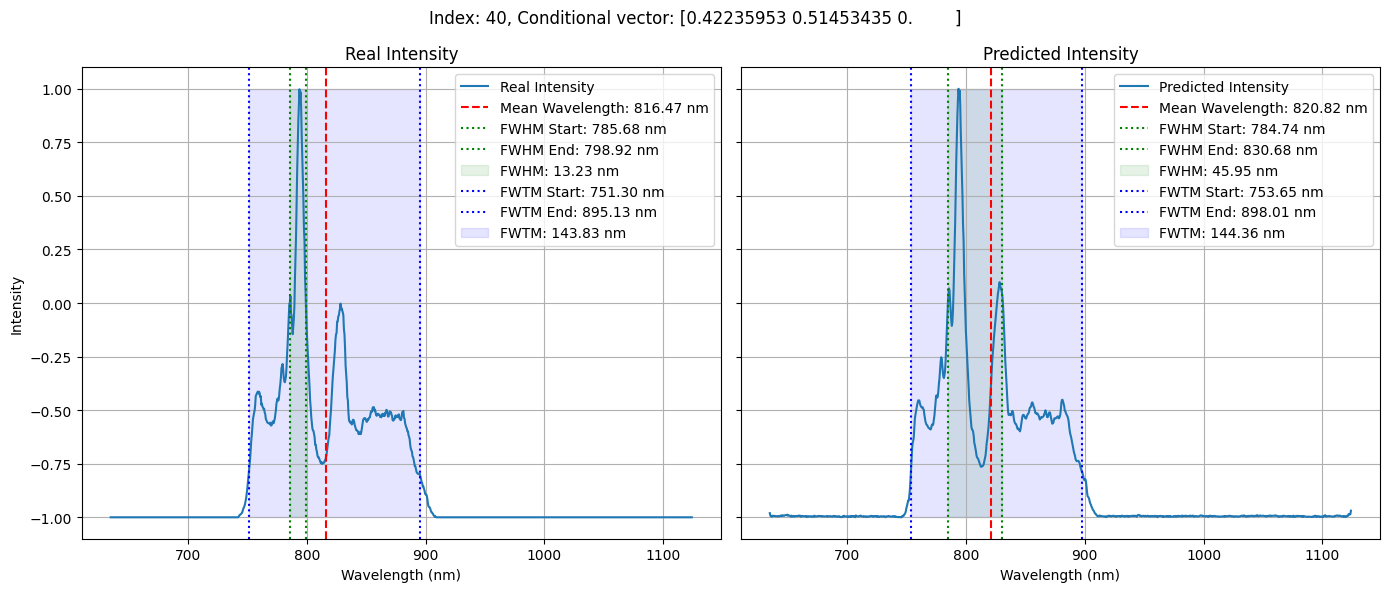

In [33]:
plot_comparison(index=40, wavelengths=wavelengths, x_real=x_real, predictions=predictions, cond_vectors=cond_vectors)

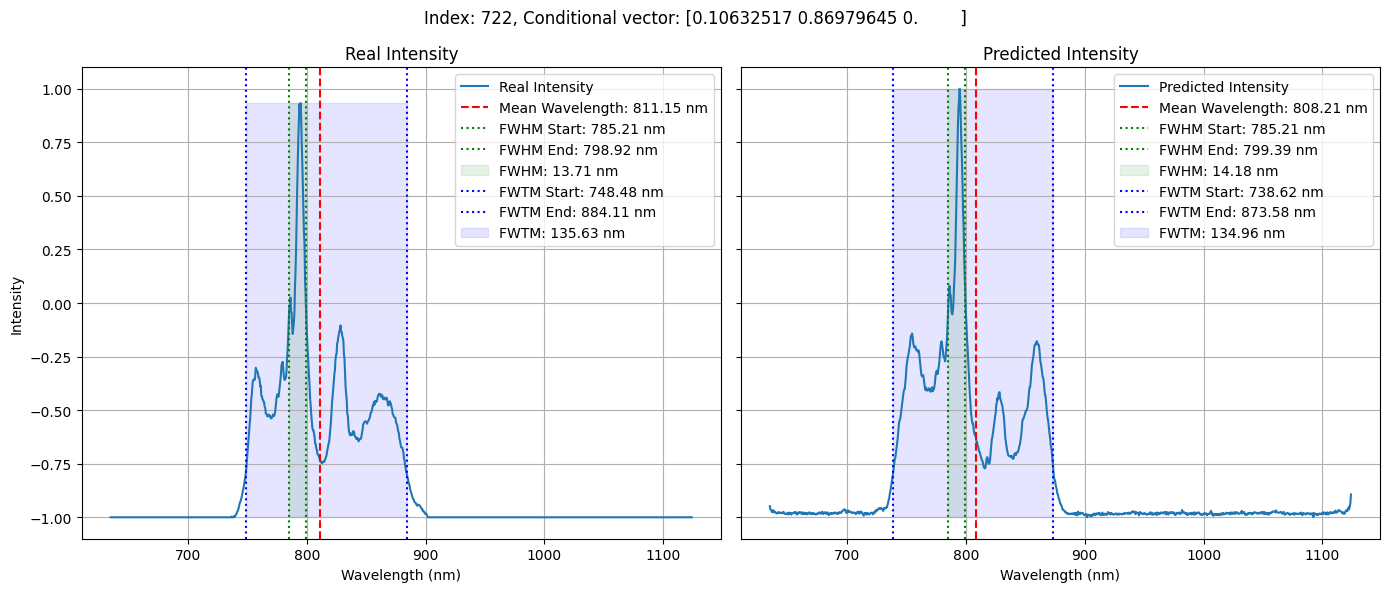

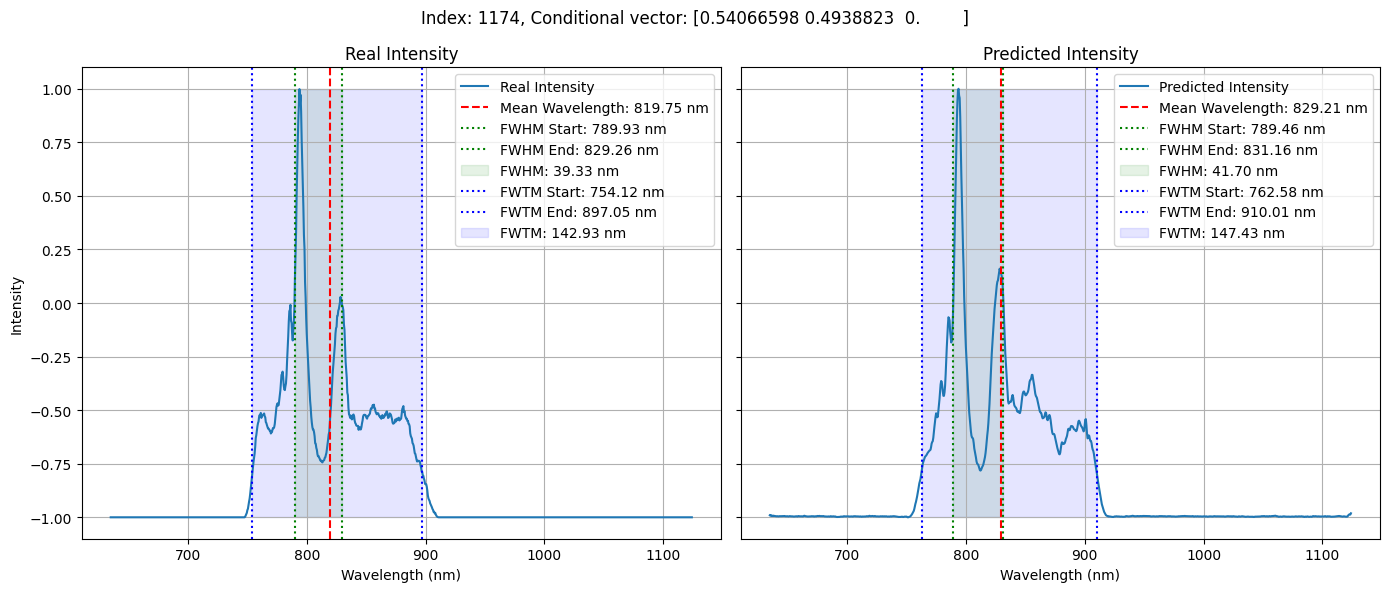

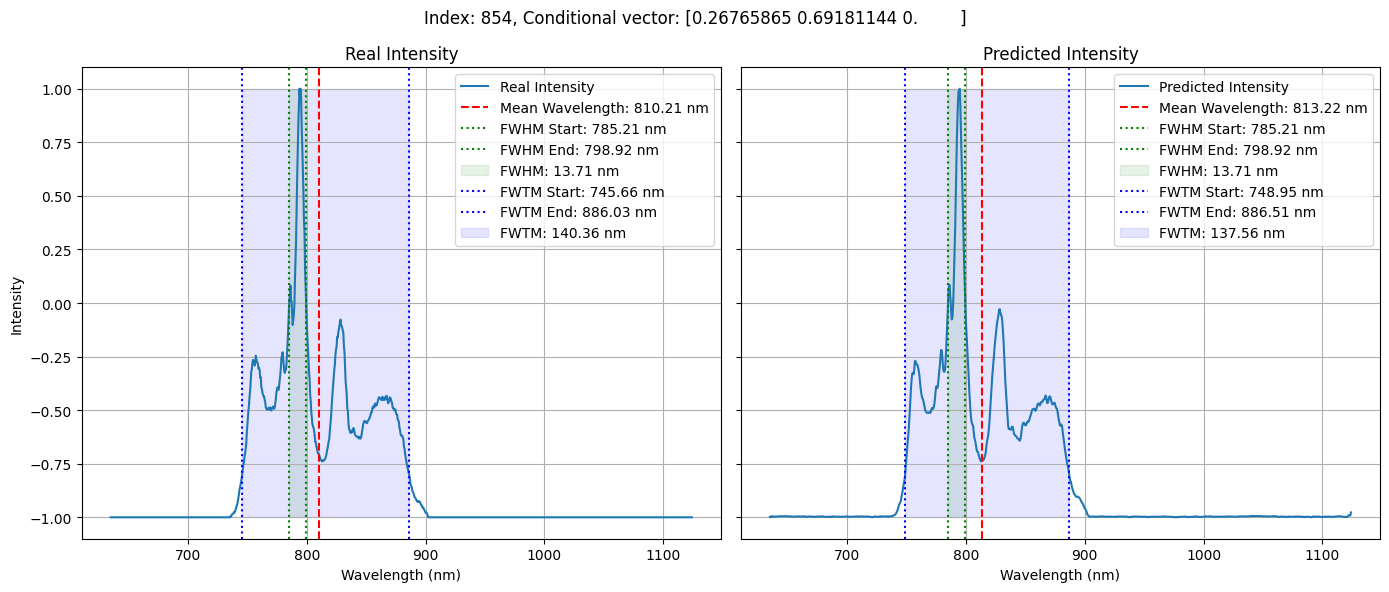

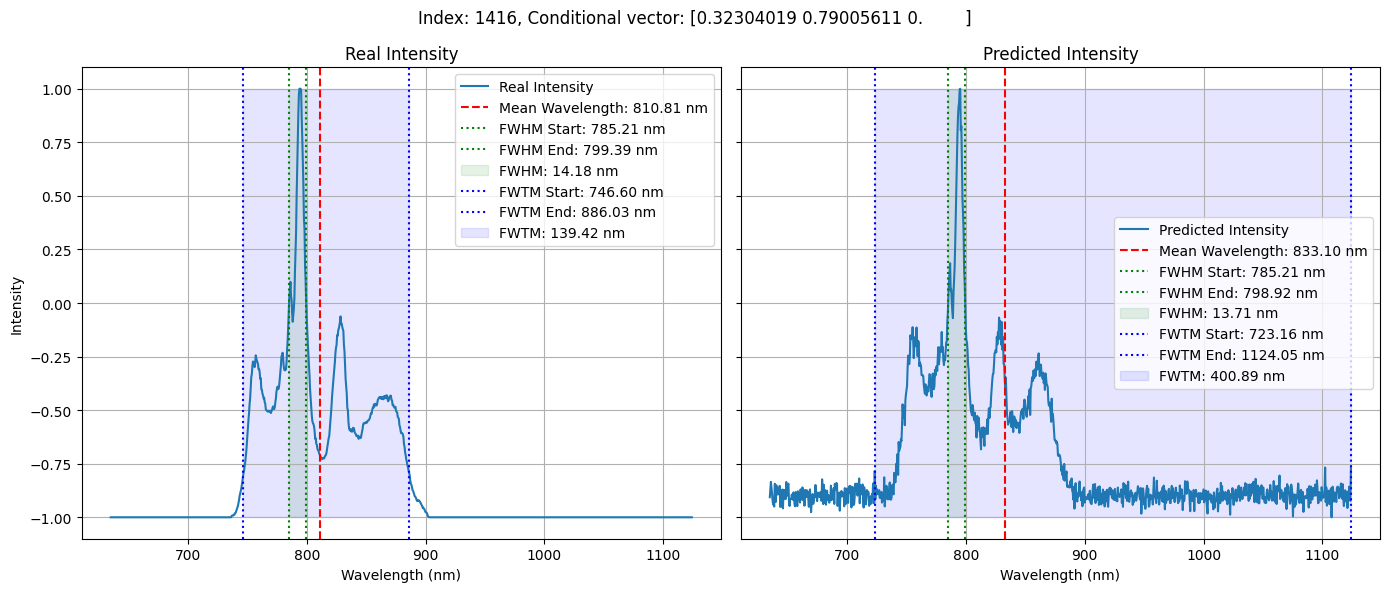

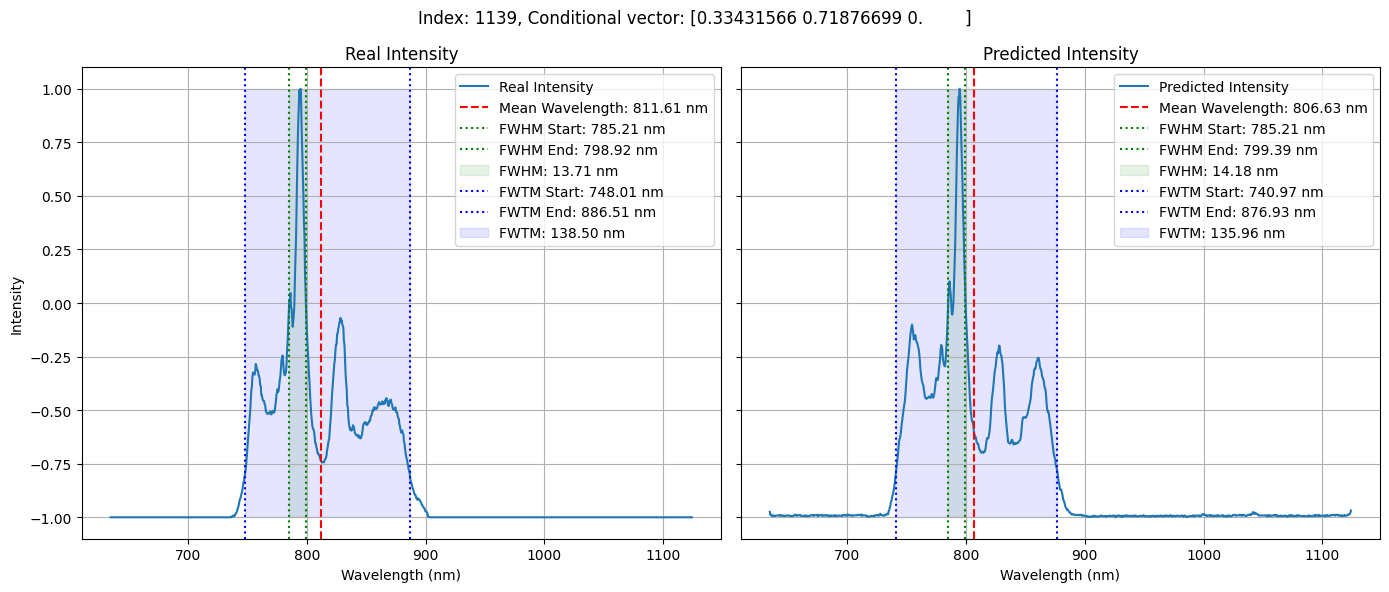

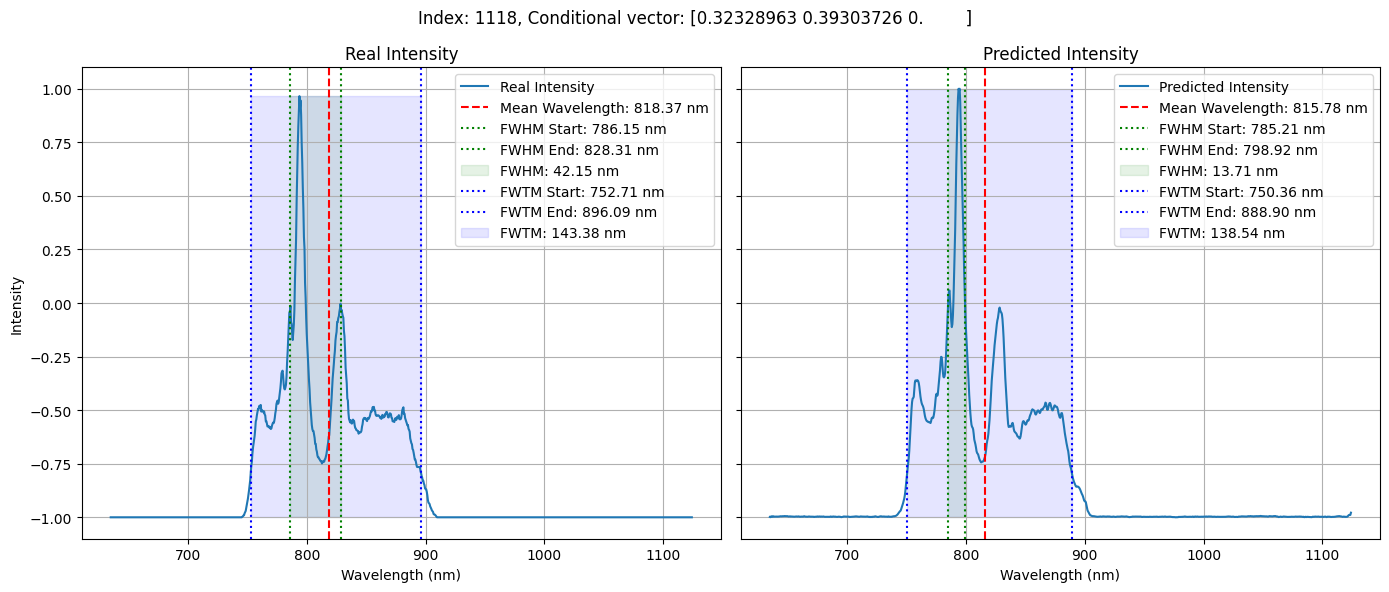

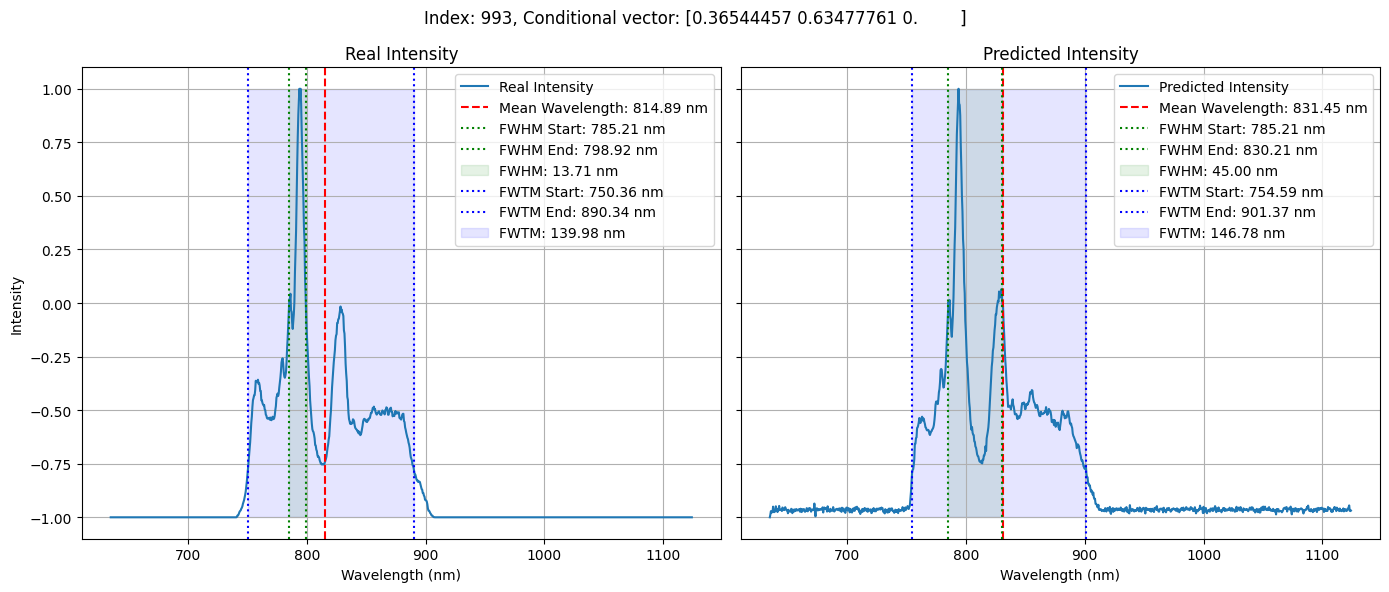

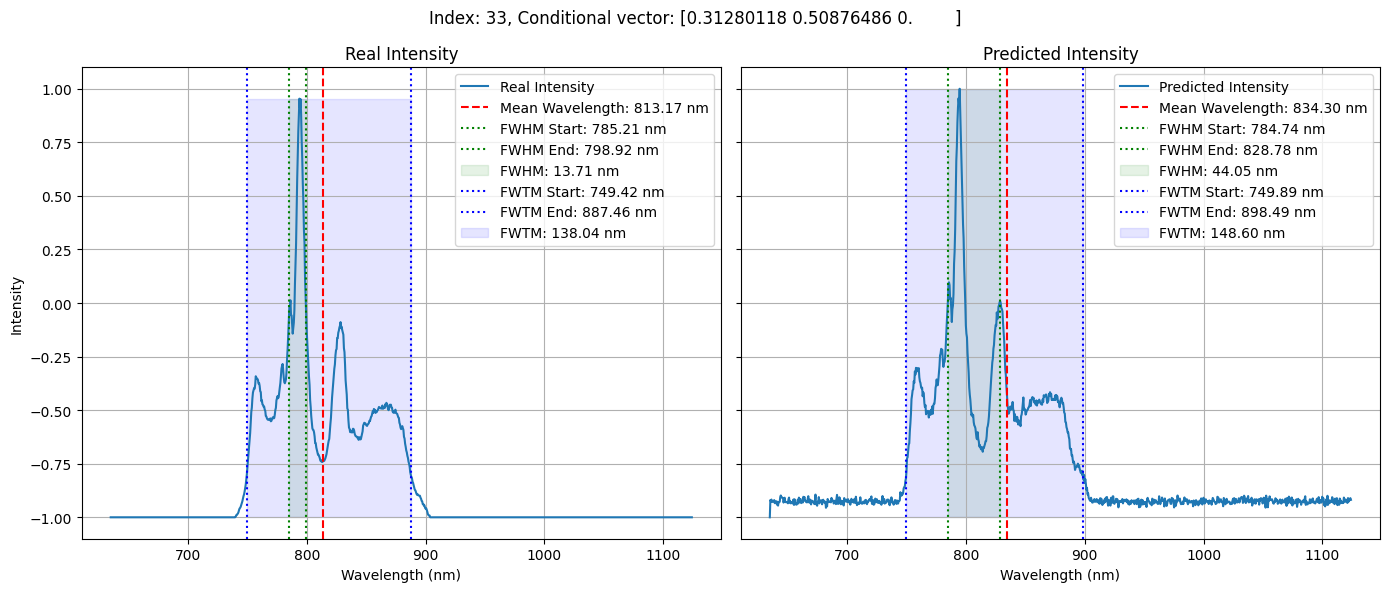

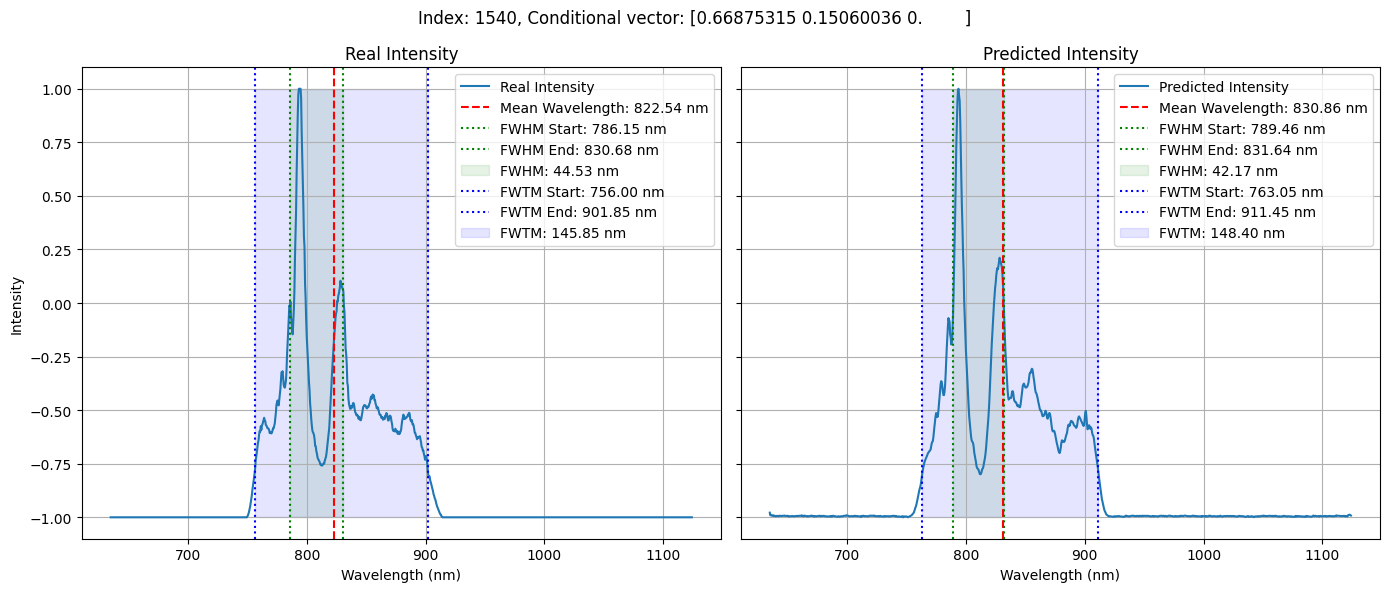

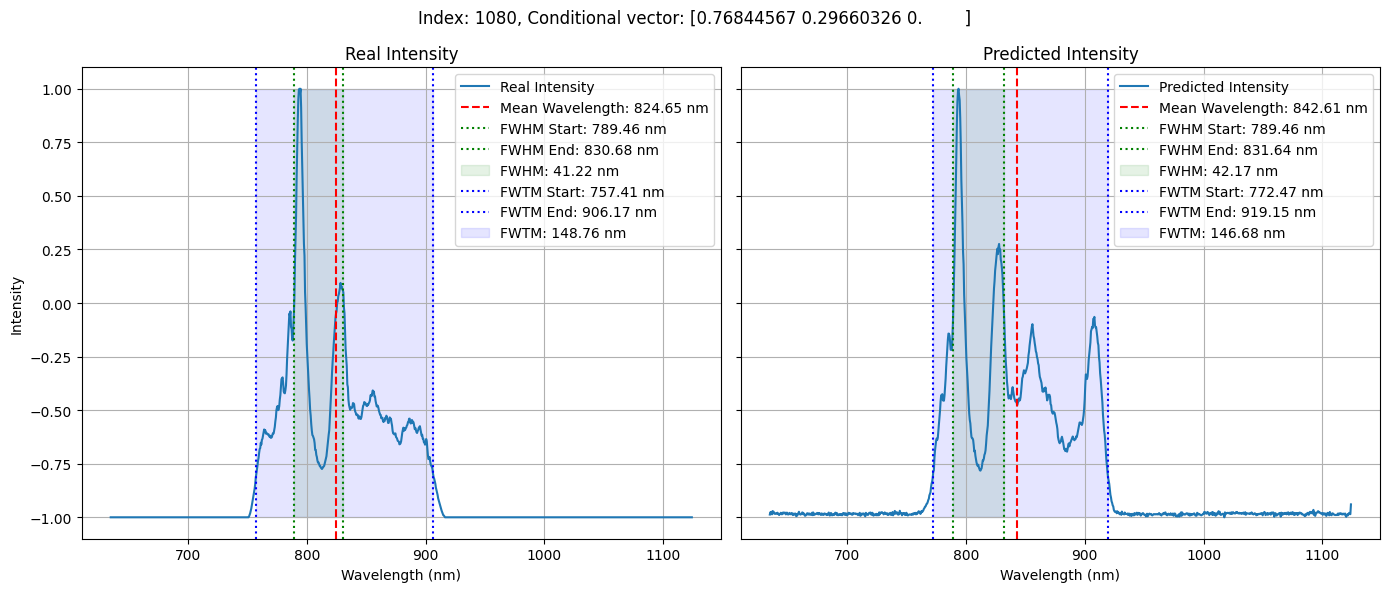

In [34]:
rand_ind = random.randint(len(x_real), size=(10))
for i in rand_ind:
    plot_comparison(index=i, wavelengths=wavelengths, x_real=x_real, predictions=predictions, cond_vectors=cond_vectors)

In [35]:
# Calculate MSE and MAE for the metrics
mse_results, mae_results = calculate_metrics_errors(wavelengths, x_real, predictions)

+-----------------+------------+----------+
| Metric          |        MSE |      MAE |
+=================+============+==========+
| mean_wavelength |  192.243   | 11.1111  |
+-----------------+------------+----------+
| std_deviation   |  707.262   | 20.5675  |
+-----------------+------------+----------+
| fwhm            |  487.126   | 13.1498  |
+-----------------+------------+----------+
| fwhm_start      |    8.93201 |  1.54082 |
+-----------------+------------+----------+
| fwhm_end        |  517.671   | 13.2571  |
+-----------------+------------+----------+
| fwtm            | 3649.36    | 16.8902  |
+-----------------+------------+----------+
| fwtm_start      |  469.113   | 10.1675  |
+-----------------+------------+----------+
| fwtm_end        | 2175.28    | 19.4166  |
+-----------------+------------+----------+


In [36]:
calculate_dtw_distances(x_real, predictions)

TypeError: unsupported operand type(s) for +: 'DTW' and 'DTW'